# Quantum Bayesian Inference with Qiskit

##### Exact inference on Bayesian networks is \#P-hard. That is why usually approximate inference is used to sample from the distribution on query variables given evidence variables. Quantum Bayesian Inference provides a method to speed up the sampling process. By employing a quantum version of rejection sampling and leveraging amplitude amplification, quantum computation achieves a significant speedup, making it possible to obtain samples much faster. This method efficiently utilizes the structure of Bayesian networks to produce quantum states that represent classical probability distributions.

##### This tutorial will guide you through the process of using the QBayesian class to perform such inference tasks. This inference algorithm implements the algorithm from the paper "Quantum inference on Bayesian networks" by Low, Guang Hao et al. This leads to a speedup per sample from $O(nmP(e)^{-1})$ to $O(n2^{m}P(e)^{-\frac{1}{2}})$, where n is the number of nodes in the Bayesian network with at most m parents per node and e the evidence.



# Step 1: Creating Rotations for Bayesian Network

In the first example we consider a simple Bayesian network that is only based on two nodes.

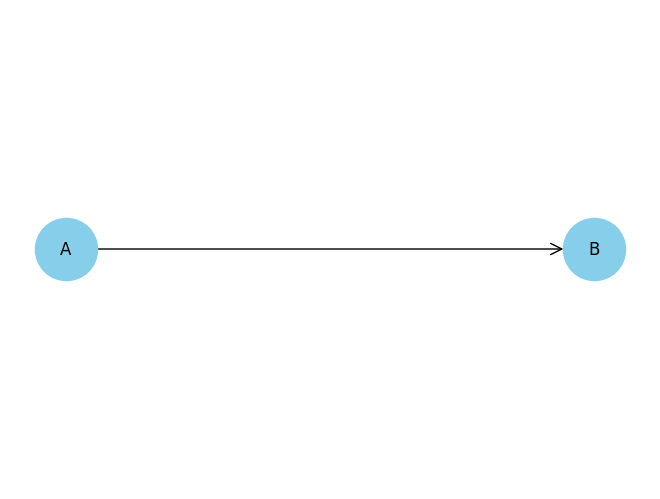

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
# Create a directed graph
G = nx.DiGraph()
# Add nodes. The nodes will be positioned at (0, 0) and (1, 0) respectively.
G.add_node('A', pos=(0, 0))
G.add_node('B', pos=(1, 0))
# Add a directed edge from A to B
G.add_edge('A', 'B')
# Get the positions of each node
pos = nx.get_node_attributes(G, 'pos')
# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', arrowstyle='->', arrowsize=20)
# Show the plot
plt.show()

For the quantum circuit we need rotation angles that represent the conditional probability tables. For example:
$$P(A)=0.2$$
$$P(B|A)=0.9$$
$$P(B|-A)=0.3$$

In [2]:
# Include libraries
import numpy as np
# Define rotation angles
theta_A = 2 * np.arcsin(np.sqrt(0.2))
theta_B_A = 2 * np.arcsin(np.sqrt(0.9))
theta_B_nA = 2 * np.arcsin(np.sqrt(0.3))

# Step 2: Create a Quantum Circuit for Bayesian Network

A Bayesian network can be represented as a quantum circuit where each node is a qubit, and the edges are quantum gates that represent the conditional dependencies.

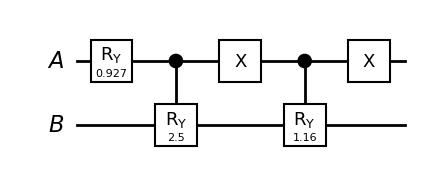

In [3]:
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
# Define quantum registers 
qrA = QuantumRegister(1, name='A')
qrB = QuantumRegister(1, name='B')
# Define a 2-qubit quantum circuit
qc = QuantumCircuit(qrA, qrB, name="Bayes net small")
#Apply the R_Y_theta rotation gate on the first qubit
qc.ry(theta_A, 0)
# Apply the controlled-R_Y_theta rotation gate
qc.cry(theta_B_A, control_qubit=qrA, target_qubit=qrB)
# Apply the X gate on the first qubit
qc.x(0)
# Apply the controlled-R_Y_theta rotation gate
qc.cry(theta_B_nA, control_qubit=qrA, target_qubit=qrB)
# Apply another X gate on the first qubit
qc.x(0)
qc.draw('mpl', style='bw', plot_barriers=False, justify='none', fold=-1)

# Step 3: Perform Inference

To use the `QBayesian` class, instantiate it with a quantum circuit that represents the Bayesian network. You can then use the `inference` method to estimate probabilities given evidence.

In [4]:
from qiskit_machine_learning.algorithms .inference import QBayesian

query = {'B': 0}
evidence = {'A': 1}
# Initialize quantum bayesian inference framework
qbayesian = QBayesian(circuit=qc)
# Inference
qbayesian.inference(query=query, evidence=evidence)

0.1181

# Step 4: Generalize the approach for n nodes

Now we generalize the approach for n nodes in a chain with random probabilities.

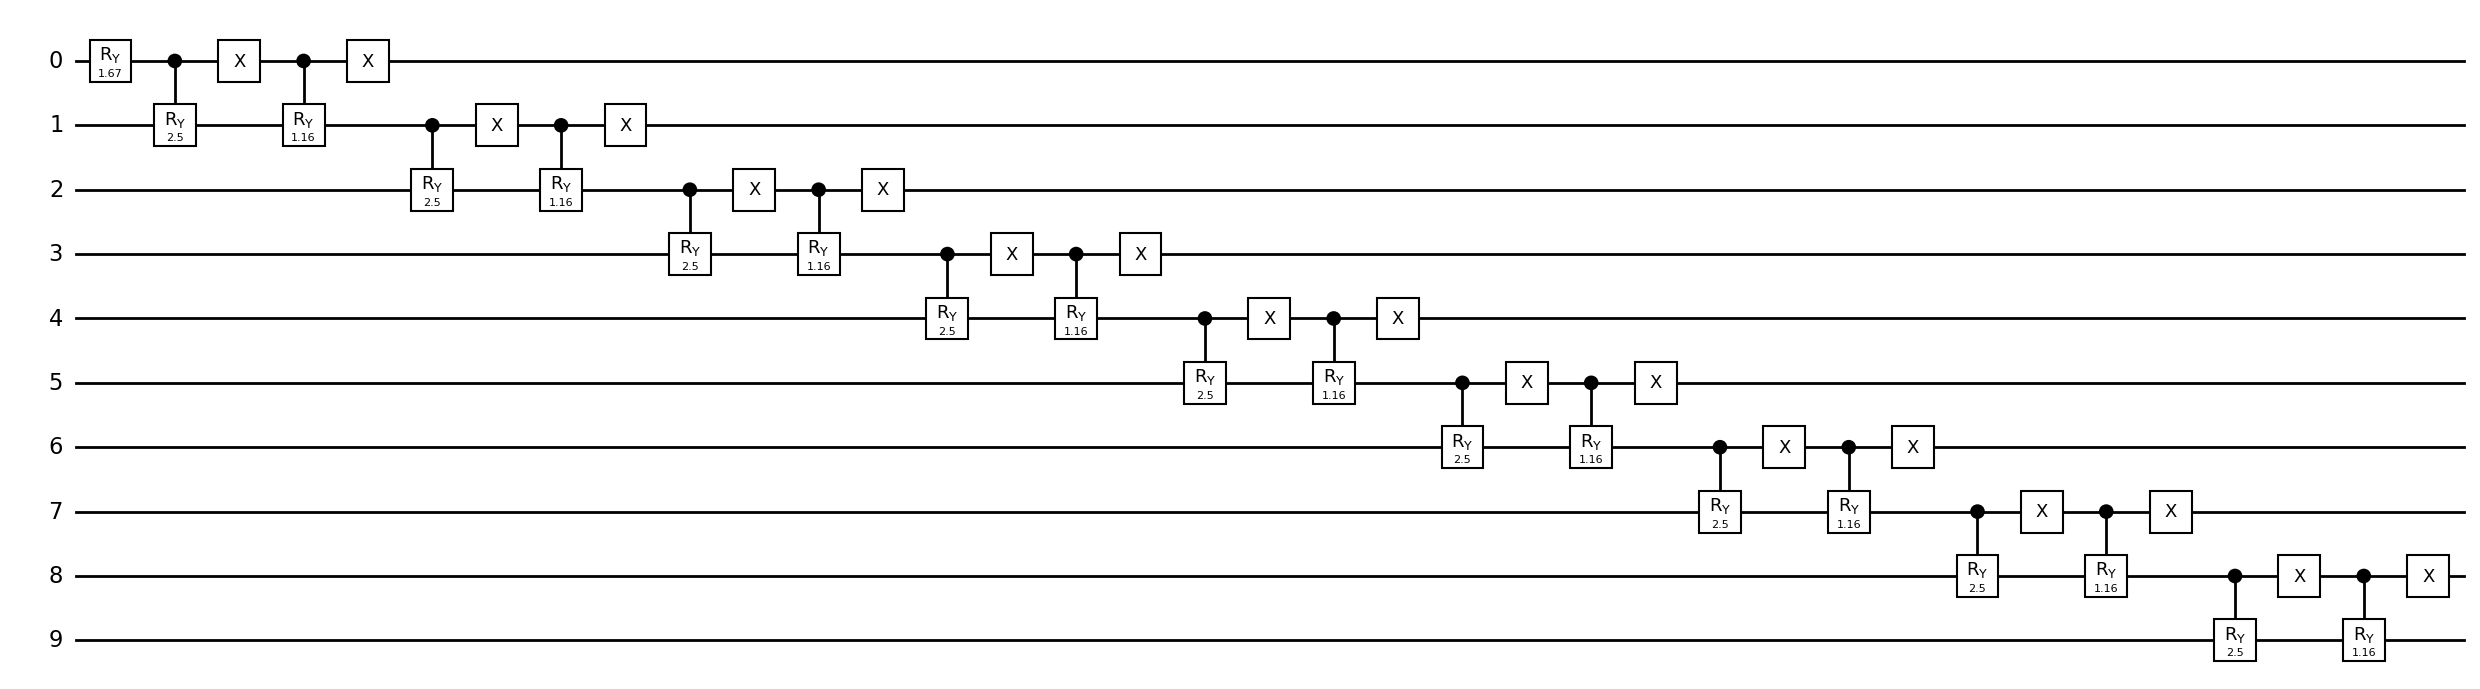

In [5]:
# Choose the number of nodes
n = 10 
# Generate probabilities
prob = np.random.random_sample(2*(n-1)+1)
theta = [2 * np.arcsin(np.sqrt(p)) for p in prob]
# Define quantum registers 
qr = [QuantumRegister(1, name=i) for i in range(n)]
# Generate circuit
qc = QuantumCircuit(*qr, name="Bayes net")
#Apply the R_Y_theta rotation gate on the first qubit
qc.ry(theta[0], 0)
# Apply the controlled-R_Y_theta rotations
for i in range(1, n, 1):
    qc.cry(theta_B_A, control_qubit=i-1, target_qubit=i)
    qc.x(i-1)
    qc.cry(theta_B_nA, control_qubit=i-1, target_qubit=i)
    qc.x(i-1)
# Draw circuit
qc.draw('mpl', style='bw', plot_barriers=False, justify='none', fold=-1)

We could also do inference with this model, but the chosen probabilities are random, as is the result.

{'1000000000': 0.5181, '0000000000': 0.4819}


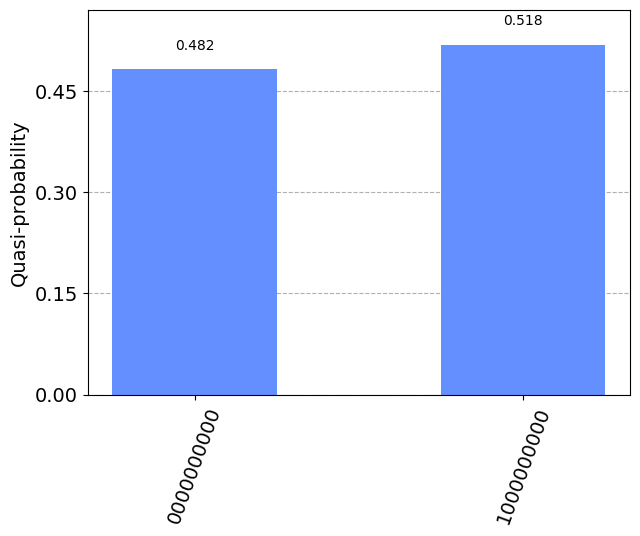

In [6]:
from qiskit.visualization import plot_histogram

evidence = {str(i): 0 for i in range(n-1)}
# Initialize quantum bayesian
qbayesian = QBayesian(circuit=qc)
# Inference
samples = qbayesian.rejection_sampling(evidence=evidence)
print(samples)
plot_histogram(samples)

# Step 5: Burglary Alarm Example: 

Imagine you have an alarm system in your house that is triggered by either a burglary or an earthquake. You also have two neighbors, John and Mary, who will call you if they hear the alarm. The network has directed edges from the Burglary and Earthquake nodes to the Alarm node, indicating that both burglary and earthquake can cause the alarm to ring. There are also edges from the Alarm node to the John Calls and Mary Calls nodes, indicating that the alarm influences whether John and Mary call you.

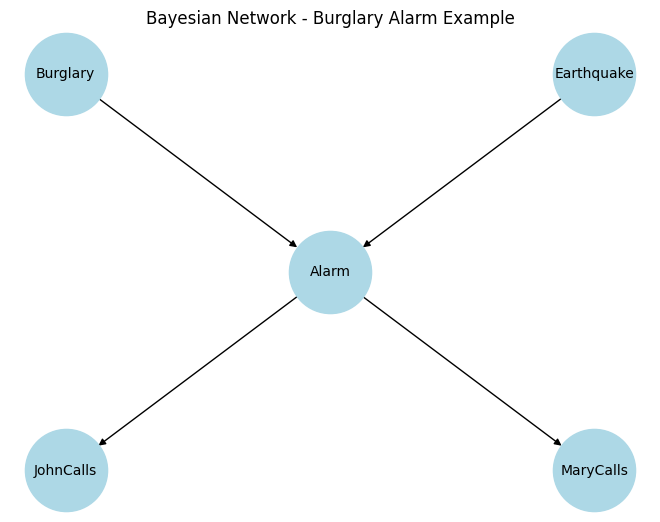

In [7]:
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()
# Add nodes
G.add_nodes_from(["Burglary", "Earthquake", "Alarm", "JohnCalls", "MaryCalls"])
# Add edges
G.add_edges_from([("Burglary", "Alarm"), ("Earthquake", "Alarm"),
                      ("Alarm", "JohnCalls"), ("Alarm", "MaryCalls")])
# Manually set positions
pos = {"Burglary": (0, 1), "Earthquake": (1, 1),
           "Alarm": (0.5, 0.5),
           "JohnCalls": (0, 0), "MaryCalls": (1, 0)}
# Draw the network
nx.draw(G, pos, with_labels=True, node_size=3500, node_color="lightblue", font_size=10)
plt.title("Bayesian Network - Burglary Alarm Example")
plt.show()
 

The Bayesian Network for this scenario involves the following variables:

Burglary (B): Whether a burglary has occurred.
Earthquake (E): Whether an earthquake has occurred.
Alarm (A): Whether the alarm goes off.
John Calls (J): Whether John calls you.
Mary Calls (M): Whether Mary calls you.

In [8]:
theta_B = 2 * np.arcsin(np.sqrt(0.001))
theta_E = 2 * np.arcsin(np.sqrt(0.002))
theta_A_nBnE = 2 * np.arcsin(np.sqrt(0.001))
theta_A_nBE = 2 * np.arcsin(np.sqrt(0.29))
theta_A_BnE = 2 * np.arcsin(np.sqrt(0.94))
theta_A_BE = 2 * np.arcsin(np.sqrt(0.95))
theta_J_nA = 2 * np.arcsin(np.sqrt(0.05))
theta_J_A = 2 * np.arcsin(np.sqrt(0.9))
theta_M_nA = 2 * np.arcsin(np.sqrt(0.9))
theta_M_A = 2 * np.arcsin(np.sqrt(0.3))

The Bayesian network can be represented by the following quantum circuit:

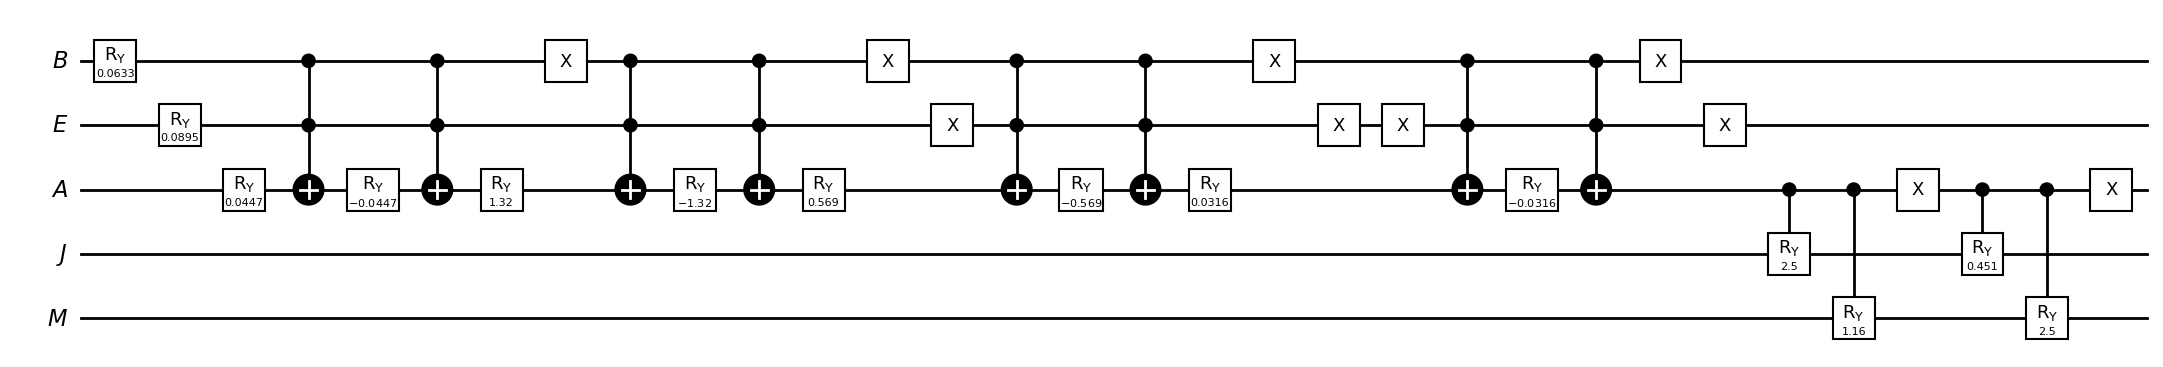

In [9]:
# Initialize register
var = ['B','E','A','J','M']
qr = [QuantumRegister(1, name=v) for v in var]
qc = QuantumCircuit(*qr, name='Pachinko')
# Specify control qubits
# P(B)
qc.ry(theta_B, qr[0])
# P(E)
qc.ry(theta_E, qr[1])
# P(A|B,E)
qc.mcry(theta_E, [qr[0][0], qr[1][0]], qr[2])
# P(A|-B,E)
qc.x(qr[0])
qc.mcry(theta_A_BnE, [qr[0][0], qr[1][0]], qr[2])
qc.x(qr[0])
# P(A|B,-E)
qc.x(qr[1])
qc.mcry(theta_A_nBE, [qr[0][0], qr[1][0]], qr[2])
qc.x(qr[1])
# P(A|-B,-E)
qc.x(qr[0])
qc.x(qr[1])
qc.mcry(theta_A_nBnE, [qr[0][0], qr[1][0]], qr[2])
qc.x(qr[0])
qc.x(qr[1])
# P(J|A)
qc.cry(theta_J_A, qr[2], qr[3])
# P(M|A)
qc.cry(theta_M_A, qr[2], qr[4])
# P(J|-A) + P(M|-A)
qc.x(qr[2])
qc.cry(theta_J_nA, qr[2], qr[3])
qc.cry(theta_M_nA, qr[2], qr[4])
qc.x(qr[2])
# Draw circuit
qc.draw('mpl', style='bw', plot_barriers=False, justify='none', fold=-1)


Using this network, you can perform various probabilistic inferences. For example, if John calls, you can calculate the probability of a burglary having occurred. Bayesian Networks are particularly useful in such scenarios where you have uncertain information (like John calling) and you want to infer the state of a more fundamental variable (like a burglary).

In [10]:
query = {'B': 1}
evidence = {'J':1}
# Initialize quantum bayesian inference framework
qbayesian = QBayesian(circuit=qc)
# Inference
qbayesian.inference(query=query, evidence=evidence)

0.8721300000000001

The joint probability can be also plot with no evidence for the rejection sampling method.

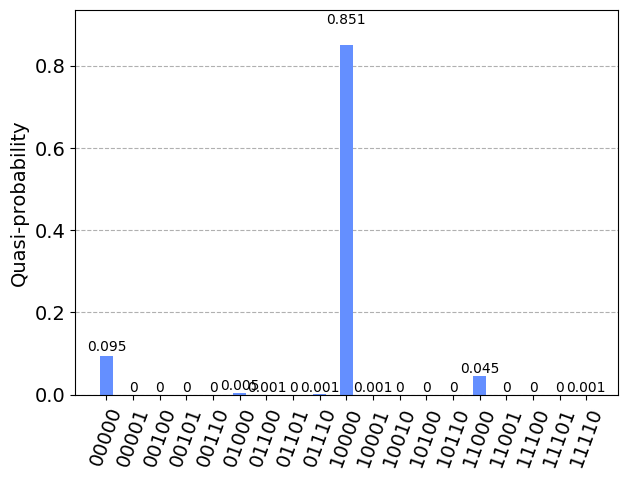

In [11]:
counts = qbayesian.rejection_sampling(evidence={})
plot_histogram({c_key: c_val for c_key, c_val in counts.items()})